## SQIG Trading Competition - The Code

In this Jupyter Notebook document, you will find the code for my SQIG Trading Competition submission. The code snippets and thought processes are split up into steps for clarity.

### Step 1: Prepare the dataset

Here, I import necessary libraries, load and inspect the given data, determine features and the target before splitting the data into training and testing sets.

In [266]:
# NOTE: If any required modules are not currently installed, run "!pip install module_name" in a cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error  # For loss function

df = pd.read_csv("SQIG_data.csv", parse_dates=True, index_col=0)

# Drop missing values first to clean data
df.dropna(inplace=True)

# Then select features and target
features = ["VIX", "T-Bill_13W_Yield", "10Y_Treasury_Yield"]
X = df[features]
y = df["Credit_Spread"]

# Then split train-test (80%-20% train-test split)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

### Step 2: Use Random Forest Regressor for baseline model

Next, I train and evaluate a Random Forest model to predict credit spreads. I compare its performance to previous models using RMSE and MAE, assess potential overfitting by checking training error and cross-validation RMSE, and analyse feature importances to understand which variables most influence credit spread dynamics.

Random Forest RMSE: 0.019970233570171733
Random Forest MAE : 0.01063742562326877
Random Forest Training RMSE: 0.010737364312078912
Random Forest CV RMSE (mean ± std): 0.0251 ± 0.0050


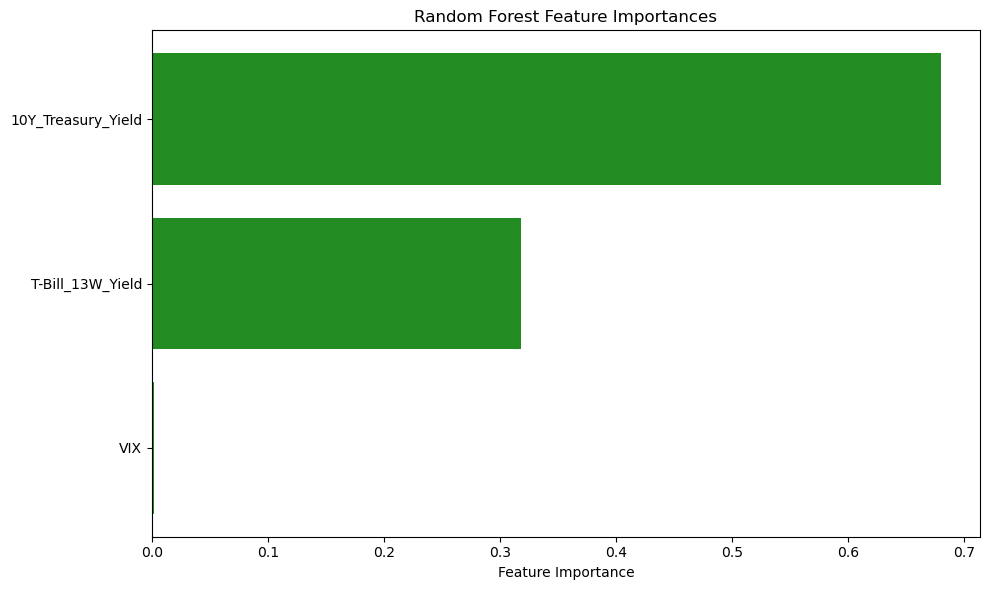

In [267]:
# Instantiate the model
rf_model = RandomForestRegressor(
    n_estimators=100,    
    max_depth=None,     
    random_state=42
)

# Fit to training data
rf_model.fit(X_train, y_train)

# Predict on test data
y_rf_pred = rf_model.predict(X_test)

# Evaluate
rf_rmse = np.sqrt(mean_squared_error(y_test, y_rf_pred))
rf_mae = mean_absolute_error(y_test, y_rf_pred)

print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest MAE : {rf_mae}")

# Also check for training RMSE for further checking
y_train_pred = rf_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Random Forest Training RMSE: {train_rmse}")

# ----------Quick check for overfitting/generalisation---------------------------
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print(f"Random Forest CV RMSE (mean ± std): {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")


# -----------Feature Importance - What does RF think matters most?---------------
importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color="forestgreen")
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

### Interpretation of Results

- Here, since the test RMSE and CV RMSE are similar, the RF model performs similarly on the test split and on unseen data during cross-validation.
- Overall, this indicates low overfitting and the model generalises well. The low STD also indicates low variability between folds, suggesting reliable predictions.
- Furthermore, the moderate gap between training and test RMSE (~0.01) supports this conclusion as it’s small enough to suggest the model is well-calibrated, rather than overfitting to the training data.
- In the above feature importance, we see that long-term yield curves dominate credit spread dynamics.

### Step 3: Leverage XGBoost for Final Model Enhancement via Gradient Boosting

Here, I apply XGBoost - a powerful gradient boosting algorithm - to predict credit spreads. I evaluate its out-of-sample performance using RMSE and MAE, compare it against the Random Forest model, and examine feature importances. I also perform cross-validation to assess generalisation and to identify whether XGBoost, despite potentially higher errors, offers better robustness and predictive stability.

XGBoost RMSE: 0.0234
XGBoost MAE : 0.0167
XGBoost CV RMSE (mean ± std): 0.0241 ± 0.0029


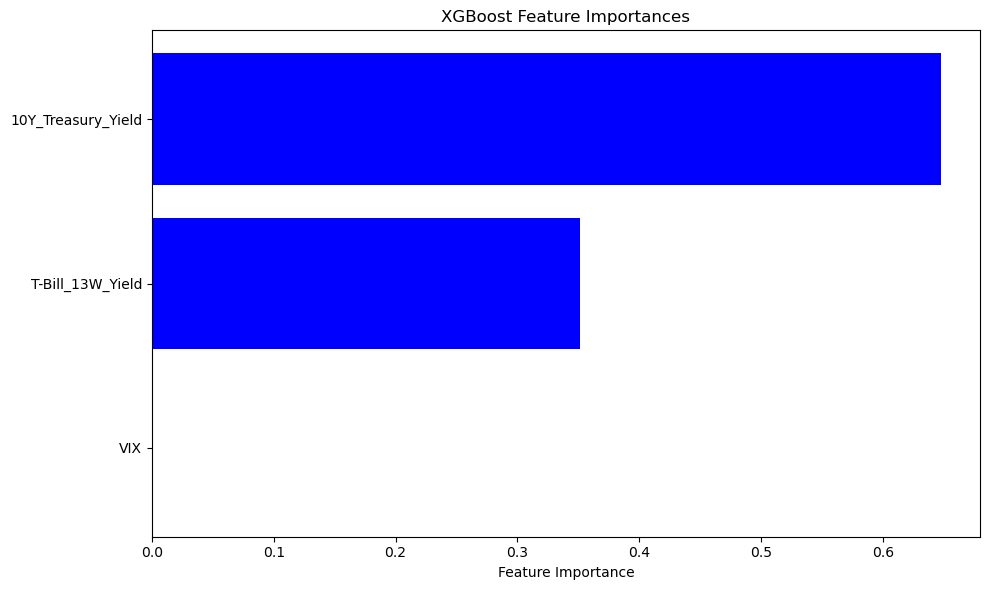

In [268]:
# Instantiate the model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train)

# Make predictions
y_xgb_pred = xgb_model.predict(X_test)

# Evaluate
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_xgb_pred))
xgb_mae = mean_absolute_error(y_test, y_xgb_pred)

print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost MAE : {xgb_mae:.4f}")

# ----------Quick check for overfitting/generalisation---------------------------
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')
xgb_cv_rmse = np.sqrt(-xgb_cv_scores)

print(f"XGBoost CV RMSE (mean ± std): {xgb_cv_rmse.mean():.4f} ± {xgb_cv_rmse.std():.4f}")

importances = xgb_model.feature_importances_
feature_names = X.columns

# Display feature importance visually
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color="blue")
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

### Interpretation of Results

Overall, looking at the difference in performance metrics (Test RMSE, Test MAE, CV RMSE and Feature Importance) between the Random Forest and XGBoost models, I can conclude that XGBoost generalises more consistently, while Random Forest performs better on this specific test split. Both models agree that the 10Y Yield is the most predictive feature, with XGBoost downplaying VIX.

Overall, the best model to move forward with is the **XGBoost model** as it generalises better (lower CV STD), is less prone to overfitting, and focuses on the most predictive features.

### Step 4: Evaluation of XGBoost

After comparing both Random Forest and XGBoost models, I finalise XGBoost as the preferred choice due to its consistent generalisation, strong performance, and built-in regularisation. I also evaluate **directional accuracy** to assess how well the model captures the trend in credit spreads, which is a critical insight for trading desks focused more on movement direction than exact values.

#### Why XGBoost?

After comparing Random Forest and XGBoost using multiple performance metrics and validation strategies, XGBoost is chosen as the final model due to the following reasons:

- **More consistent generalisation:** XGBoost showed lower cross-validation RMSE variance (±0.0029), which indicates stable performance across data splits.

- **Competitive performance:** While Random Forest slightly outperformed on the test set, XGBoost's test RMSE of 0.0234 and MAE of 0.0167 remain strong and within close range.

- **Feature Parsimony:** XGBoost places more weight on short- and long-term yields while virtually ignoring VIX, suggesting a leaner, more noise-resistant model.

- **Regularisation:** XGBoost uses L1/L2 regularisation, helping reduce overfitting tendencies.

#### Use Case: Custom Prediction with XGBoost

Let’s simulate a prediction using user-defined inputs for:

- VIX

- 13-Week T-Bill Yield

- 10-Year Treasury Yield

In [269]:
user_input  = pd.DataFrame([{
    "VIX": 16.0,
    "T-Bill_13W_Yield": 0.8,
    "10Y_Treasury_Yield": 2.4
}])

xgb_predicted_credit_spread = xgb_model.predict(user_input)[0]
print(f"Predicted Credit Spread: {xgb_predicted_credit_spread:.4f}")

Predicted Credit Spread: 1.5759


#### Interpretation of Predicted Credit Spread

Hopefully, the above use case shows how a user (or financial analyst) could input current market conditions and **instantly receive a model-driven credit spread estimate**, which they can then use for real-time risk assessment or pricing decisions.

#### Directional Accuracy Evaluation

Now, I assess the directional accuracy of the model i.e. how well the model predicts the direction of change in the target variable (credit spread).

In [270]:
# Predicted and actual values
y_test_shifted = y_test.shift(1).dropna()
y_pred_shifted = pd.Series(y_xgb_pred, index=y_test.index).shift(1).dropna()

# Align for comparison
y_actual_diff = y_test.loc[y_test_shifted.index] - y_test_shifted
y_pred_diff = pd.Series(y_xgb_pred, index=y_test.index).loc[y_test_shifted.index] - y_pred_shifted

# Directional match (both up or both down??)
correct_direction = np.sign(y_actual_diff) == np.sign(y_pred_diff)
directional_accuracy = correct_direction.sum() / len(correct_direction)

print(f"Directional Accuracy: {directional_accuracy:.2%}")

Directional Accuracy: 99.45%


#### Interpretation of Directional Accuracy Results:

The high directional accuracy above (~99%) implies that the model reliably anticipates market trends in credit spreads.

This benefit is especially useful for credit traders and portfolio strategists, who potentially care more about the **direction of movement** than precise spread values.

### Step 5: Interpretability and Strategic Takeaways

In this step, I use the XGBoost model's predicted credit spreads to build a weekly trading strategy that dynamically adjusts ETF allocations based on macro risk regimes. By combining predicted spread levels with VIX, I classify each week as either "High Risk" or "Low Risk" and allocate accordingly - favouring defensive ETFs in high-risk environments and growth-oriented ETFs when risk is low. A directional spread signal (tightening/widening) adds tactical nuance. This section also includes a review of strategic takeaways and suggestions for improving both the model and the strategy going forward.

As a reminder, I have already analysed feature importance for both Random Forest and XGBoost.

XGBoost Feature Weights (approximate):

- 10Y_Treasury_Yield: most important (e.g. 0.65)

- T-Bill_13W_Yield: moderate to high

- VIX: minimal

### Intepretation of Feature Weights

- Long-term yield curve movements carry strong signals for credit spreads.

- Short-term rates add value (perhaps tied to Fed expectations).

- VIX, while conceptually relevant, was not statistically dominant here. This may be because its signals are already captured in yields or lagged spreads.

Overall, this aligns with economic theory: credit spreads react to perceived macro/credit risk, which is reflected in both yield curves and implied volatility.

### Regime-Wise Error Analysis

I now analyse model error across different market regimes, to spot where it performs better or worse as this will help inform a regime-switching strategy.

In [271]:
# Define regimes using VIX and credit spread
regime = np.where((df["VIX"] < 20) & (df["Credit_Spread"] < 1.5), "Low Risk", "High Risk")
df["Regime"] = regime

# Create an independent copy
X_test = X_test.copy()

# Add model predictions and errors to test set portion
X_test["Predicted_CS"] = y_xgb_pred
X_test["Actual_CS"] = y_test
X_test["Error"] = np.abs(X_test["Predicted_CS"] - X_test["Actual_CS"])

# Add regime information
X_test["Regime"] = df.loc[X_test.index, "Regime"]

# MAE by regime
error_by_regime = X_test.groupby("Regime")["Error"].mean()

print(error_by_regime)

Regime
High Risk    0.016996
Low Risk     0.015826
Name: Error, dtype: float64


### Interpretation of Error Analysis Figures

The errors by regime above show the following:

- The XGBoost model performs slightly better in the Low Risk regime, with a lower average prediction error.

- The difference in MAE between the regimes is very small (~0.0012), suggesting the model is robust across macro regimes.

- This is a strong result, particularly since model performance often suffers more under high-risk or volatile conditions.

### Credit Trading Strategy using our XGBoost Model

Now, I create a macro volatility-aware trading strategy that:

- Uses XGBoost model predictions of credit spreads.

- Dynamically switches ETF allocations based on regime (Low Risk vs High Risk).

- Responds to model-predicted spread changes rather than just raw market data.

- Compares strategy vs benchmark performance.

In [272]:
# Recalculate Regime using model-predicted Credit Spread
predicted_cs_full = xgb_model.predict(X)
df["Predicted_CS"] = predicted_cs_full

df["Regime_ModelBased"] = np.where(
    (df["VIX"] < 20) & (df["Predicted_CS"] < 1.5),
    "Low Risk",
    "High Risk"
)

# Which ETFs to hold in each regime
etf_allocation = {
    "Low Risk": ["ARKQ", "QCLN", "BOTZ"],
    "High Risk": ["ICLN", "ROBO"]
}

# -----------------Simulate Allocations based on predicted regimes-----------------------
# Weekly rebalancing
df.index = pd.to_datetime(df.index, dayfirst=True)
df_weekly = df.resample("W").last()  # Weekly frequency

# Determine ETFs held weekly
df_weekly["ETFs_Held"] = df_weekly["Regime_ModelBased"].map(etf_allocation)


# --------------------Trading Signalling----------------------------------
df_weekly["Spread_Change"] = df_weekly["Predicted_CS"].diff()

df_weekly["Signal"] = np.where(
    df_weekly["Spread_Change"] > 0, "Widening",
    np.where(df_weekly["Spread_Change"] < 0, "Tightening", "Stable")
)

print(df_weekly[["Predicted_CS", "Regime_ModelBased", "ETFs_Held", "Signal"]].tail(10))

            Predicted_CS Regime_ModelBased           ETFs_Held      Signal
2024-11-03      1.711593         High Risk        [ICLN, ROBO]    Widening
2024-11-10      2.275236         High Risk        [ICLN, ROBO]    Widening
2024-11-17      1.572839         High Risk        [ICLN, ROBO]  Tightening
2024-11-24      1.132635         High Risk        [ICLN, ROBO]  Tightening
2024-12-01      1.308338         High Risk        [ICLN, ROBO]    Widening
2024-12-08      2.075295         High Risk        [ICLN, ROBO]    Widening
2024-12-15      1.785254         High Risk        [ICLN, ROBO]  Tightening
2024-12-22      1.334622          Low Risk  [ARKQ, QCLN, BOTZ]  Tightening
2024-12-29      1.287945         High Risk        [ICLN, ROBO]  Tightening
2025-01-05      1.421260         High Risk        [ICLN, ROBO]    Widening


### Interpretation of Trading Strategy

The model-generated weekly signals create a dynamic, macro-aware trading strategy that uses predicted credit spreads and VIX to determine market regimes, and adjust ETF exposure accordingly.

Strategy Logic Recap:
- Model predicts credit spread (Predicted_CS) each week.

- A regime is classified as:

    - Low Risk → VIX < 20 and Predicted_CS < 1.5

    - High Risk → All other cases.

- ETF exposure shifts weekly based on regime.

- Spread direction signal (Widening, Tightening, Stable) adds tactical overlay.


**Code Output Breakdown:**

| Week       | Predicted\_CS | Regime       | ETFs Held            | Signal     | Interpretation                                                        |
| ---------- | ------------- | ------------ | -------------------- | ---------- | --------------------------------------------------------------------- |
| 2024-11-03 | 1.71          | High Risk    | ICLN, ROBO           | Widening   | Risk regime → stay defensive, spreads worsening.                      |
| 2024-11-10 | 2.28          | High Risk    | ICLN, ROBO           | Widening   | Continue defensive allocation.                                        |
| 2024-11-17 | 1.57          | High Risk    | ICLN, ROBO           | Tightening | Early signal of potential risk easing, but still in High Risk regime. |
| 2024-11-24 | 1.13          | High Risk    | ICLN, ROBO           | Tightening | Spread tightening, but regime hasn't shifted yet.                     |
| 2024-12-01 | 1.31          | High Risk    | ICLN, ROBO           | Widening   | Regime remains High Risk → continue defensive.                        |
| 2024-12-08 | 2.07          | High Risk    | ICLN, ROBO           | Widening   | Deteriorating credit → risk-off still preferred.                      |
| 2024-12-15 | 1.79          | High Risk    | ICLN, ROBO           | Tightening | Slight relief, but regime hasn’t flipped.                             |
| 2024-12-22 | 1.33          | **Low Risk** | **ARKQ, QCLN, BOTZ** | Tightening | First flip to Low Risk → rotate into and hold more growth-oriented ETFs.            |
| 2024-12-29 | 1.29          | High Risk    | ICLN, ROBO           | Tightening | Regime back to High Risk (VIX may have risen).                        |
| 2025-01-05 | 1.42          | High Risk    | ICLN, ROBO           | Widening   | Worsening again → hold defensive ETFs.                                |

**Summary of Trading Strategy**

The trading logic above implements:

Regime Switching
- Allocates to either growth ETFs (e.g., ARKQ, QCLN, BOTZ) or defensive ETFs (e.g., ICLN, ROBO) weekly based on model-based credit stress signals.

Directional Overlay
- Helps confirm or challenge allocation decisions.

- Example: Even if you're in a High Risk regime, consistent tightening signals may indicate easing risk, which could be a potential precursor to a regime flip.

**Use Case for a Credit Trading Desk**

A credit desk can use this as a **quantitative overlay** or a **signal-generation tool** in:

Risk-On / Risk-Off Positioning
- Model-guided signals help the desk rotate between IG, HY, credit derivatives, or macro ETFs accordingly.

Forward-Looking Signal
- Trading desks typically use backward-looking indicators. This approach uses forward-looking credit spread movement (tightening/widening), offering lead-time vs. lagged indicators.

Cross-Asset Allocation Overlay
- The ETF rotation can be adapted to sector bets (e.g., long growth, short cyclical), or macro hedges based on stress projections.

### Suggestions for Improvement

Below are some potential model and strategy improvements:

#### Model Improvements

- More macro features: Include rate hikes, employment, inflation surprises.

- Time series dynamics: Add rolling window features, momentum indicators.

- More asset-specific factors: Add credit-specific measures (like CDX or OAS).

- Model calibration: Use cross-validation over different economic cycles.

#### Strategy Improvements

To improve the above strategy, we could:

- Have ETF Price Data Integration:
    - Add historical prices using yfinance or Bloomberg to simulate real performance.
    - Calculate returns, drawdowns, Sharpe ratio, etc.

- Consider Thoroughly Backtesting the Strategy:

    - Test regime-switching logic vs. a benchmark (e.g., SPY or LQD).

**Closing Remarks**

In conclusion, the XGBoost model used here to predict credit spreads and give signals to guide ETF allocation between growth and defensive assets is far from complete. Still, this forward-looking approach helps credit trading desks manage risk proactively, though full evaluation requires ETF price data and further enhancements.